## Model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [10]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is NOT AVAILABLE


In [12]:
# Tham số
IMG_SIZE = (224, 224)  # Điều chỉnh theo kích thước ảnh của bạn
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 15  # Thay đổi theo số lượng class thực tế

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

TRAIN_PATH='../dataset/train'
VAL_PATH='../dataset/val/'
TEST_PATH='../dataset/test/'
NOISE_PATH='../dataset/noise_2/'
MODEL_PATH='../model/best_model_v17.keras'

In [13]:
# Tạo data generators
train_datagen = ImageDataGenerator(
    rescale=1./224,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./224)

# Tạo data loaders
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

noise_generator = val_test_datagen.flow_from_directory(
    NOISE_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 52500 images belonging to 15 classes.
Found 11250 images belonging to 15 classes.
Found 11250 images belonging to 15 classes.
Found 5000 images belonging to 15 classes.


In [14]:
# read Model
model=tf.keras.models.load_model(MODEL_PATH)

In [15]:
# Đánh giá trên noise set
noise_loss, noise_acc = model.evaluate(noise_generator)
print(f'Noise loss: {noise_loss}')
print(f'Noise accuracy: {noise_acc}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 640s 4s/step - accuracy: 0.5105 - loss: 2.5991
Noise loss: 1.7433830499649048
Noise accuracy: 0.5532000064849854


In [16]:
# print error on train and validation
# train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(val_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

# print(f'Train loss: {train_loss}, Train accuracy: {train_accuracy}')
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

352/352 ━━━━━━━━━━━━━━━━━━━━ 1491s 4s/step - accuracy: 0.8961 - loss: 0.2952
352/352 ━━━━━━━━━━━━━━━━━━━━ 1534s 4s/step - accuracy: 0.9279 - loss: 0.2198
Validation loss: 0.29956409335136414, Validation accuracy: 0.8907555341720581
Test loss: 0.31537240743637085, Test accuracy: 0.8848000168800354


In [ ]:
# Chuyển đổi mô hình sang định dạng TensorFlow Lite với lượng tử hóa
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Lưu mô hình đã lượng tử hóa
with open('model_quantized.tflite', 'wb') as f:
    f.write(tflite_model)

## Plot

### Confusion matrix

In [ ]:
# Dự đoán
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Labels
labels = test_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred]

# Thực tế
y_test = test_generator.classes
true_labels = [labels[k] for k in y_test]

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels.values(), yticklabels=labels.values(), cmap='Greens')
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

  6/352 ━━━━━━━━━━━━━━━━━━━━ 24:03 4s/step

In [ ]:
classification_report(true_labels, predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 137s 869ms/step


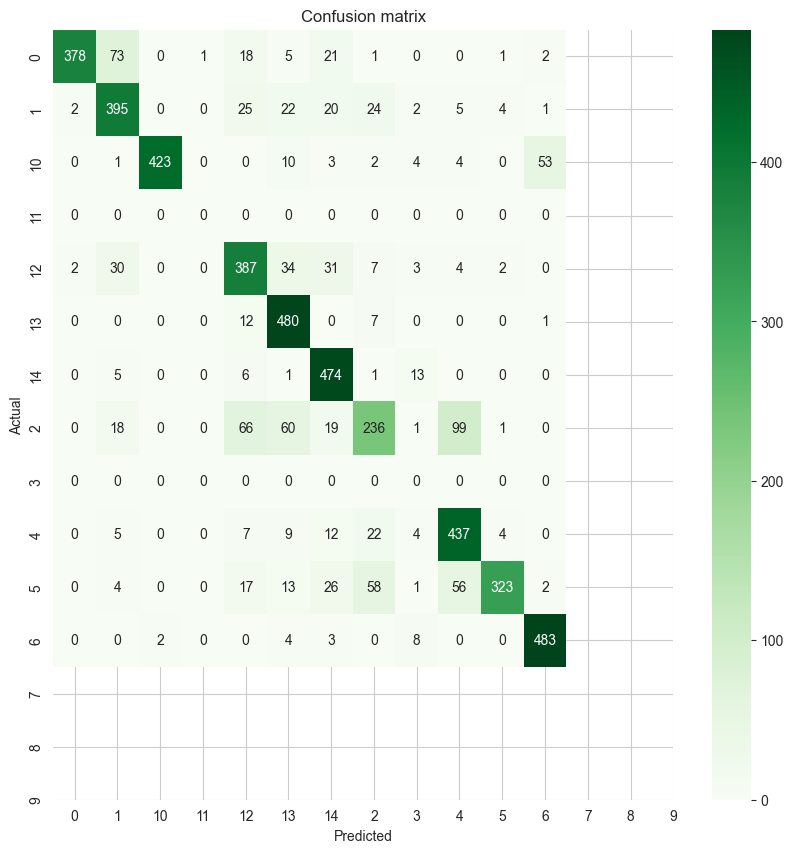

In [11]:
# Dự đoán
Y_pred = model.predict(noise_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Labels
labels = noise_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred]

# Thực tế
y_test = noise_generator.classes
true_labels = [labels[k] for k in y_test]

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels.values(), yticklabels=labels.values(), cmap='Greens')
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
classification_report(true_labels, predictions)

In [12]:
# Dự đoán
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Labels
labels = val_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred]

# Thực tế
y_test = val_generator.classes
true_labels = [labels[k] for k in y_test]

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels.values(), yticklabels=labels.values(), cmap='Greens')
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
classification_report(true_labels, predictions)